In [30]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [31]:
g = 1
v, Q = 1, 1
N = 512
D = 512
a = 0.0625
m = 0
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/P=*/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [32]:
#
D = 128
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{m=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex ), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs ), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt), allow_pickle=True).item()


In [33]:
fex

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/ex/state_D=128.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/ex/state_D=128_boosted.npy']

In [34]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)
K = Boost(N, m, g, a, ops)

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

In [12]:
fns

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=0.0000.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=1.0000.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=10.0000.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=11.0000.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=12.0000.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/P=0.0000/x0=1.5000/sg2=0.2500/D0=128/dt=0.0625/D=512/tol=1e-06/12site/state_t=13.0000.npy',
 '/home/marek/pdf/./results_fe

In [35]:
ts = np.linspace(0, 14, 15)
Ps = [0, 1, 2, 4, 6, 8]
psi_t = {(t, P): yastn.from_dict(np.load(fn_mass(fns, t=t, P=P), allow_pickle=True).item()['psi']) for t in ts for P in Ps}
chis = [x for x in d_boost['chis'] if x <= 2]
psi_chi = {chi: yastn.from_dict(d_boost['psi'][ii]) for ii, chi in enumerate(chis)}


In [36]:
probs = {}
for (t, P), pt in psi_t.items():
    print(t, P)
    if P == 8:
        for chi, pc in psi_chi.items():
            if (t, P, chi) not in probs:
                probs[t, P, chi] = np.abs(mps.vdot(pt, pc)) ** 2


0.0 0
0.0 1
0.0 2
0.0 4
0.0 6
0.0 8
1.0 0
1.0 1
1.0 2
1.0 4
1.0 6
1.0 8
2.0 0
2.0 1
2.0 2
2.0 4
2.0 6
2.0 8
3.0 0
3.0 1
3.0 2
3.0 4
3.0 6
3.0 8
4.0 0
4.0 1
4.0 2
4.0 4
4.0 6
4.0 8
5.0 0
5.0 1
5.0 2
5.0 4
5.0 6
5.0 8
6.0 0
6.0 1
6.0 2
6.0 4
6.0 6
6.0 8
7.0 0
7.0 1
7.0 2
7.0 4
7.0 6
7.0 8
8.0 0
8.0 1
8.0 2
8.0 4
8.0 6
8.0 8
9.0 0
9.0 1
9.0 2
9.0 4
9.0 6
9.0 8
10.0 0
10.0 1
10.0 2
10.0 4
10.0 6
10.0 8
11.0 0
11.0 1
11.0 2
11.0 4
11.0 6
11.0 8
12.0 0
12.0 1
12.0 2
12.0 4
12.0 6
12.0 8
13.0 0
13.0 1
13.0 2
13.0 4
13.0 6
13.0 8
14.0 0
14.0 1
14.0 2
14.0 4
14.0 6
14.0 8


In [ ]:
# np.save(f"probs_{m=}.npy", probs, allow_pickle=True)
# probs = np.load(f"probs_{m=}.npy", allow_pickle=True).item()

In [37]:
probs_gs = {(t, PP): np.abs(mps.vdot(pt, psi_gs)) ** 2 for (t, PP), pt in psi_t.items() if PP == 8}

(0.001, 10.0)

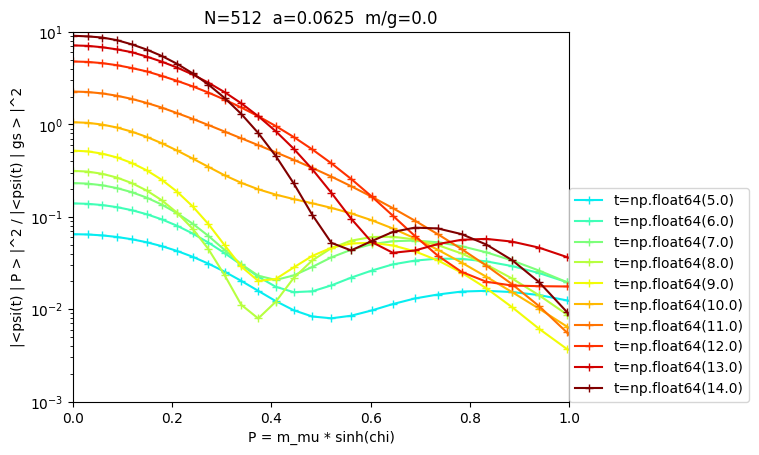

In [45]:
cm = plt.cm.jet
PP = 8
for t in ts[5:]:
    pr = [probs[t, PP, chi] / probs_gs[t, PP] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    plt.semilogy(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2 / |<psi(t) | gs > |^2")
plt.legend(loc=(1, 0))
plt.xlim([0, 1])
plt.title(f"N=512  a=0.0625  {m/g=}")
plt.ylim([1e-3, 1e1])